# Bayesian Neural Network MCMC
Part of the Bayesian neural networks via MCMC: a Python-based tutorial

This section of the tutorial covers the development of an MCMC algorithm applied to a Neural Network.

### Imports

In [2]:
%pdb 1
%load_ext autoreload
%autoreload 2

Automatic pdb calling has been turned ON


In [77]:
import numpy as np
import pandas as pd
from scipy.stats import binom, uniform
from ipywidgets import interact, fixed, widgets
from tqdm import tqdm
# visulisation function
from functions.visualisations import histogram_trace, plot_y_timeseries, plot_ycorr_scatter

## Define a class with the functions and attributes required for a neural network model

- `predict`: Function to output y given the input data and model parameters - $y = b + w x$
- `backward_pass`: Function to update the model parameters given the input data and the gradient of the loss function 
    - $\bar{\theta_p} = \theta_p + r \times \nabla E_{y_{\mathcal{A}_{D,T}}}\left[\theta_p\right]$
    - $\nabla E_{y_{\mathcal{A}_{D,T}}}\left[\theta_p\right] = \left(\frac{\delta E}{\delta \theta_1},\dots, \frac{\delta E}{\delta \theta_L} \right)$
    - $E_{y_{\mathcal{A}_{D,T}}}\left[\theta_p\right] = \sum_{t \in \mathcal{A}_{D,T}} \left(y_t - f\left(x_t\right)^{[k]}\right)^2$
- `evaluate_proposal`: Outer function to evaluate a given proposal distribution using predict

In [34]:
class NeuralNetwork:
    '''
    Neural Network model with a single hidden layer and a single output (y)
    '''
    def __init__(self, layer_sizes):
        '''
        Initialize the model
        Input:
            - layer_sizes (input, hidden, output): array specifying the number of nodes in each layer
        '''
        # Initial values of model parameters
        self.input_num = layer_sizes[0]
        self.hidden_num = layer_sizes[1]
        self.output_num = layer_sizes[2]

        self.n_params = (self.input_num * self.hidden_num) + (self.hidden_num * self.output_num) +\
            self.hidden_num + self.output_num
        # learning params
        self.lrate = 0.01

        # Initialize network structure
        self.initialise_network()
    
    def initialise_network(self):
        # Initialize network structure - weights and biases for the hidden layer and output layer
        
        # hidden layer
        self.l1_weights = np.random.normal(
            loc=0, scale=1/np.sqrt(self.input_num),
            size=(self.input_num, self.hidden_num))
        self.l1_biases = np.random.normal(
            loc=0, scale=1/np.sqrt(self.hidden_num), 
            size=(self.hidden_num,))
        # placeholder for storing the hidden layer values
        self.l1_output = np.zeros((1, self.hidden_num))

        # output layer
        self.l2_weights = np.random.normal(
            loc=0, scale=1/np.sqrt(self.hidden_num), 
            size=(self.hidden_num, self.output_num))
        self.l2_biases = np.random.normal(
            loc=0, scale=1/np.sqrt(self.hidden_num), 
            size=(self.output_num,))
        # placeholder for storing the model outputs
        self.l2_output = np.zeros((1, self.output_num))

    # Function to take in data and parameter sample and return the prediction
    def evaluate_proposal(self, x_data, w):  # BP with SGD (Stocastic BP)
        '''
        Use the model to predict and then evaluate the proposal
        Input:
            data: (N x num_features) array of data
            w: (num_features + 1) vector of parameters. 
                The last element of w consitutes the bias term (giving num_fearures + 1 elements)
        '''
        self.decode(w)  # method to decode w into W1, W2, B1, B2.
        size = x_data.shape[0]

        fx = np.zeros(size)

        for i in range(0, size):  # to see what fx is produced by your current weight update
            fx[i] = self.forward_pass(x_data[i,])

        return fx
    
    # NN prediction
    def forward_pass(self, X): 
        l1_z = np.dot(X, self.l1_weights) + self.l1_biases
        self.l1_output = self.sigmoid(l1_z)
        l2_z = np.dot(self.l1_output, self.l2_weights) + self.l2_biases
        self.l2_output = self.sigmoid(l2_z)
        return self.l2_output
    
    def backward_pass(self, X, Y):
        '''
        Compute the gradients using a backward pass to enable Langevin-gradient updating
        Input:
            - X: (N x num_features) array of input data
            - Y: (N) array of target data
        '''
        # XX Maybe some intution on how we got here - sigmoid + chain rule + backpropagation
        # dE/dtheta
        l2_delta = (Y - self.l2_output) * (self.l2_output * (1 - self.l2_output))
        l2_weights_delta = np.outer(
            self.l1_output,
            l2_delta
        )
        # backprop of l2_delta and same as above
        l1_delta = np.dot(l2_delta,self.l2_weights.T) * (self.l1_output * (1 - self.l1_output))        
        l1_weights_delta = np.outer(
            X,
            l1_delta
        )

        # update for output layer
        self.l2_weights += self.lrate * l2_weights_delta
        self.l2_biases += self.lrate * l2_delta
        # update for hidden layer
        self.l1_weights += self.lrate * l1_weights_delta
        self.l1_biases += self.lrate * l1_delta

    def langevin_gradient(self, x_data, y_data, w, depth):  # BP with SGD (Stocastic BP)
        self.decode(w)  # method to decode w into W1, W2, B1, B2.
        size = x_data.shape[0]      
        for i in range(0, depth):
            for i in range(0, size):
                pat = i
                # Input = data[pat, 0:self.Top[0]]
                # Desired = data[pat, self.Top[0]:]
                self.forward_pass(x_data[pat,])
                self.backward_pass(x_data[pat,], y_data[pat])
        w_updated = self.encode()
        return  w_updated

    # Helper functions
    def sigmoid(self, x):
        '''Implentation of the sigmoid function'''
        return 1 / (1 + np.exp(-x))
        
    def encode(self):
        w1 = self.l1_weights.ravel()
        w2 = self.l2_weights.ravel()
        w = np.concatenate([w1, w2, self.l1_biases, self.l2_biases])
        return w
        
    def decode(self, w):
        '''
        Take in a vector of parameters and update the model accordingly
        '''
        w_layer1size = self.input_num * self.hidden_num
        w_layer2size = self.hidden_num * self.output_num

        w_layer1 = w[0:w_layer1size]
        self.l1_weights = np.reshape(w_layer1, (self.input_num, self.hidden_num))

        w_layer2 = w[w_layer1size:w_layer1size + w_layer2size]
        self.l2_weights = np.reshape(w_layer2, (self.hidden_num, self.output_num))
        self.l1_biases = w[w_layer1size + w_layer2size:w_layer1size + w_layer2size + self.hidden_num]
        self.l2_biases = w[w_layer1size + w_layer2size + self.hidden_num:w_layer1size + w_layer2size + self.hidden_num + self.output_num]



## Define a class for the MCMC sampling

$y=f\left(x,\theta\right)+e, e ~N\left(0,\tau^2\right)$

In [66]:
class MCMC:
    def __init__(self, n_samples, n_burnin, x_data, y_data, layer_sizes):
        self.n_samples = n_samples # number of MCMC samples
        self.n_burnin = n_burnin # number of burn-in samples
        self.x_data = x_data # (N x num_features)
        self.y_data = y_data # (N x 1)

        # MCMC parameters - defines how much variation you need in changes to theta, tau
        # XX should bring these out of here to facilitate the tutorial
        self.step_theta = 0.02;  
        self.step_eta = 0.01; # note eta is used as tau in the sampler to consider log scale.  

        # initisalise the linear model class
        self.model = NeuralNetwork(layer_sizes)
        self.use_langevin_gradients = True
        self.sgd_depth = 1
        self.l_prob = 0.5 # likelihood prob
        self.theta_size = self.model.n_params # weights for each feature and a bias term

        # store output
        self.pos_theta = None
        self.pos_tau = None
        self.rmse_data = None

    # Define the likelihood function
    def likelihood_function(self, theta, tausq):
        fx = self.model.evaluate_proposal(self.x_data, theta) 
        accuracy = self.rmse(fx, self.y_data) #RMSE 
        loss = -0.5 * np.log(2 * np.pi * tausq) - 0.5 * np.square(self.y_data - fx) / tausq
        return [np.sum(loss), fx, accuracy] 

    # Define the prior
    def prior_likelihood(self, sigma_squared, nu_1, nu_2, theta, tausq): 
        n_params = self.theta_size # number of parameters in model
        part1 = -1 * (n_params / 2) * np.log(sigma_squared)
        part2 = 1 / (2 * sigma_squared) * (sum(np.square(theta)))
        log_loss = part1 - part2 - (1 + nu_1) * np.log(tausq) - (nu_2 / tausq)
        return log_loss

    # Additional error metric
    def rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())

    # MCMC sampler
    def sampler(self):
        '''
        Run the sampler for a defined linear model
        '''
        # define empty arrays to store the sampled posterior values
        # posterior of all weights and bias over all samples
        pos_theta = np.ones((self.n_samples, self.theta_size)) 
        # posterior defining the variance of the noise in predictions
        pos_tau = np.ones((self.n_samples, 1))

        # record output f(x) over all samples
        pred_y = np.ones((self.n_samples, self.x_data.shape[0]))
        # record the RMSE of each sample
        rmse_data = np.zeros(self.n_samples)

        ## Initialisation
        # initialise theta
        theta = np.random.randn(self.theta_size)
        # make initial prediction
        pred_y[0,] = self.model.evaluate_proposal(self.x_data, theta)

        # initialise eta
        eta = np.log(np.var(pred_y[0,] - self.y_data))
        tau_proposal = np.exp(eta)

        # XX
        sigma_squared = 25  # considered by looking at distribution of  similar trained  models - i.e distribution of weights and bias
        nu_1 = 0
        nu_2 = 0

        # calculate the prior likelihood
        prior_likelihood = self.prior_likelihood(sigma_squared, nu_1, nu_2, theta, tau_proposal)
        # calculate the likelihood considering observations
        [likelihood, pred_y[0,], rmse_data[0]] = self.likelihood_function(theta, tau_proposal)

        n_accept = 0  
        n_langevin = 0
        # Run the MCMC sample for n_samples
        for ii in tqdm(np.arange(1,self.n_samples)):
            # Sample new values for theta and tau
            theta_proposal = theta + np.random.normal(0, self.step_theta, self.theta_size)

            lx = np.random.uniform(0,1,1)
            if (self.use_langevin_gradients is True) and (lx< self.l_prob):  
                theta_gd = self.model.langevin_gradient(self.x_data, self.y_data, theta.copy(), self.sgd_depth)  
                theta_proposal = np.random.normal(theta_gd, self.step_theta, self.theta_size)
                theta_proposal_gd = self.model.langevin_gradient(self.x_data, self.y_data, theta_proposal.copy(), self.sgd_depth) 
                # first = np.log(multivariate_normal.pdf(w , w_prop_gd , sigma_diagmat)) 
                # numerator - how likely is w given w_prop_gd
                # second = np.log(multivariate_normal.pdf(w_proposal , w_gd , sigma_diagmat)) 
                # denominator

                # for numerical reasons, we will provide a simplified implementation that simplifies
                # the mvn of the proposal distribution
                # This needs to be much better explained in the text and made clear where we have 
                # gone from a symmetric proposal to needing to eval q

                # detailed balance condition - eq 26
                # first is top, second is bottom - gives q ratio

                wc_delta = (theta - theta_proposal_gd) 
                wp_delta = (theta_proposal - theta_gd)

                sigma_sq = self.step_theta

                first = -0.5 * np.sum(wc_delta * wc_delta) / sigma_sq  # this is wc_delta.T  *  wc_delta /sigma_sq
                second = -0.5 * np.sum(wp_delta * wp_delta) / sigma_sq

                diff_prop =  first - second  
                n_langevin += 1
            else:
                diff_prop = 0
                theta_proposal = np.random.normal(theta, self.step_theta, self.theta_size)

            # eta proposal
            eta_proposal = eta + np.random.normal(0, self.step_eta, 1)
            tau_proposal = np.exp(eta_proposal)   

            # calculate the prior likelihood
            prior_proposal = self.prior_likelihood(
                sigma_squared, nu_1, nu_2, theta_proposal, tau_proposal
            )  # takes care of the gradients
            # calculate the likelihood considering observations
            [likelihood_proposal, pred_y[ii,], rmse_data[ii]] = self.likelihood_function(
                theta_proposal, tau_proposal
            )

            # since we using log scale: based on https://www.rapidtables.com/math/algebra/Logarithm.html
            diff_likelihood = likelihood_proposal - likelihood
            diff_priorlikelihood = prior_proposal - prior_likelihood

            mh_prob = min(1, np.exp(diff_likelihood + diff_priorlikelihood + diff_prop))

            u = np.random.uniform(0, 1)

            if u < mh_prob:
                # Update position
                #print    (i, ' is accepted sample')
                n_accept += 1
                # update
                likelihood = likelihood_proposal
                prior_likelihood = prior_proposal
                theta = theta_proposal
                eta = eta_proposal
                # print (likelihood, prior_likelihood, rmsetrain, rmsetest, w, 'accepted')
                # and store
                pos_theta[ii,] = theta_proposal
                pos_tau[ii,] = tau_proposal
            else:
                # store
                pos_theta[ii,] = pos_theta[ii-1,]
                pos_tau[ii,] = pos_tau[ii-1,]

         
        accept_ratio = (n_accept / self.n_samples) * 100

        print(accept_ratio, '% was accepted')
        # print(langevin_count, ' langevin_count')

        self.pos_theta = pos_theta[self.n_burnin:, ]
        self.pos_tau = pos_tau[self.n_burnin:, ] 
        self.rmse_data = rmse_data[self.n_burnin:]

        results_dict = {'w{}'.format(_): self.pos_theta[:, _].squeeze() for _ in range(self.theta_size-1)}
        results_dict['b'] = self.pos_theta[:, -1].squeeze()
        results_dict['tau'] = self.pos_tau.squeeze()
        results_dict['rmse'] = self.rmse_data.squeeze()
        
        # return (pos_w, pos_tau, fxtrain_samples, fxtest_samples, rmse_train, rmse_test, accept_ratio)
        results_df = pd.DataFrame.from_dict(
            results_dict
        )
        return results_df

    def model_draws(self, num_draws = 10, verbose=False):
        # let us next test the Bayesian model using the posterior distributions over n trials
        accuracy = np.zeros(num_draws)
        rmse_data = np.zeros(num_draws) 
        pred_y = np.zeros((num_draws, self.x_data.shape[0]))

        for ii in range(num_draws):
            theta_drawn = np.random.normal(self.pos_theta.mean(axis=0), self.pos_theta.std(axis=0), self.theta_size)
            tausq_drawn = np.random.normal(self.pos_tau.mean(), self.pos_tau.std())

            [likelihood_proposal, pred_y[ii,], rmse_data[ii]] = self.likelihood_function(
                theta_drawn, tausq_drawn
            )
            if verbose:
                print(
                    'Draw {} - RMSE: {:.3f}. Theta: {}, Tau {}'.format(
                        ii, rmse_data[ii], theta_drawn, tausq_drawn
                    )
                )
        return pred_y

## Load the data
- Load in the suspot data
- You can also load in the other regeression datasets `Lazer` and `Energy`

In [72]:
# load the data
train_data   = np.loadtxt("data/Sunspot/train.txt")
test_data    = np.loadtxt("data/Sunspot/test.txt")
name        = "Sunspot"
hidden      = 5
input       = 4  #
output      = 1
prob_type   = 'regression' 

print('Training data shape: {}'.format(train_data.shape))
print('\n'.join(['Variable']))

In [73]:
train_data.shape

(298, 5)

## Sample using MCMC

- Create the MCMC loop and sample the posterior distribution

In [74]:
## MCMC Settings and Setup
n_samples   = 5000 # number of samples to draw from the posterior
burn_in     = int(n_samples* 0.5) # number of samples to discard before recording draws from the posterior

# Generate toy data
n_data      = 100
n_features  = 2
x_data      = np.repeat(np.expand_dims(np.linspace(0, 1, n_data),axis=-1),n_features,axis=1)
y_data      = 0.1 * x_data[:,0] + 0.5 * (x_data[:,1] ** 2)  + 0.1 + np.random.randn(n_data) * 0.05
y_data      = y_data 
layer_sizes = [n_features, 10, 1]

# or load from sunspot data
x_data = train_data[:,:-1]
y_data = train_data[:,-1]
layer_sizes = [x_data.shape[1], 10, 1]

# Initialise the MCMC class
mcmc = MCMC(n_samples, burn_in, x_data, y_data,layer_sizes)
# Run the sampler
results = mcmc.sampler()
# Draw sample models from the posterior
pred_y = mcmc.model_draws(100)

100%|██████████| 4999/4999 [01:37<00:00, 51.37it/s]


21.72 % was accepted


## Analyse the results
Plot the data with the mean linear fit and some uncertainty.

Plot the posterior distribution and trace for each parameter using ipywidgets.

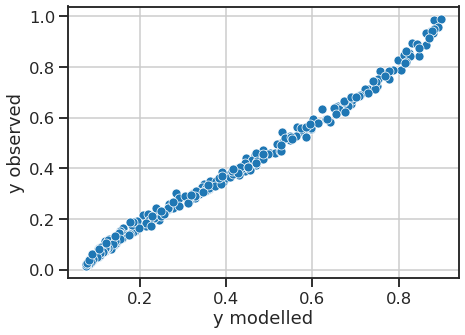

In [75]:
# plot the data with the model predictions from posterior draws
plot_ycorr_scatter(
    y_data,
    pred_y
)

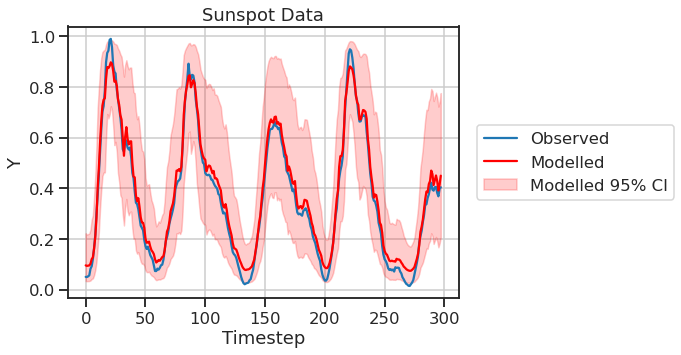

In [84]:
plot_y_timeseries(
    y_data,
    pred_y,
    dataset_name=name,
    ci=True
)

In [76]:
def plot_hist(results, param_name):
    # results = results_rmse
    posterior_mean = results[param_name].mean()
    print('{:.3f} mean value of posterior'.format(posterior_mean))
    histogram_trace(results[param_name].values)

# use ipywidgets to get a "gui" dropdown to view all the parameters
interact(
    plot_hist, 
    results=fixed(results), 
    param_name=widgets.Dropdown(
        options=results.columns,
        value='w0',
        description='Parameter:',
    )
)

interactive(children=(Dropdown(description='Parameter:', options=('w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w…

<function __main__.plot_hist(results, param_name)>